# Image Recognition

Submitted by: Ephi Frankel



In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2

from glob import glob #  https://docs.python.org/3.6/library/glob.html#module-glob
import re             #  https://docs.python.org/3/library/re.html

In [2]:
# load training images and label them

dict = {'apple':0, 'car':1, 'cow':2, 'dog':3, 'horse':4, 'pear':5, 'tomato':6}
inv_dict = {v: k for k, v in dict.items()}
fnames=glob('train\*.png')

train_images = []
train_labels = np.zeros(len(fnames))

for i,f in enumerate(fnames):
    name,ext = f.split('.')
    name = re.sub(r'[\d_-]', '', name)
    name = name.split('\\')[-1]
    
    im = cv2.imread(f,0)
    train_images.append(im)
    
    lbl = dict[name]
    train_labels[i] = lbl
    print((f,name,lbl))
    

('train\\apple1-090-180.png', 'apple', 0)
('train\\apple2-090-180.png', 'apple', 0)
('train\\apple3-090-180.png', 'apple', 0)
('train\\apple4-090-180.png', 'apple', 0)
('train\\apple5-090-180.png', 'apple', 0)
('train\\apple6-090-180.png', 'apple', 0)
('train\\apple7-090-180.png', 'apple', 0)
('train\\apple8-090-180.png', 'apple', 0)
('train\\apple9-090-180.png', 'apple', 0)
('train\\car1-090-180.png', 'car', 1)
('train\\car11-090-180.png', 'car', 1)
('train\\car12-090-180.png', 'car', 1)
('train\\car2-090-180.png', 'car', 1)
('train\\car3-090-180.png', 'car', 1)
('train\\car5-090-180.png', 'car', 1)
('train\\car6-090-180.png', 'car', 1)
('train\\car7-090-180.png', 'car', 1)
('train\\car9-090-180.png', 'car', 1)
('train\\cow1-090-180.png', 'cow', 2)
('train\\cow2-090-180.png', 'cow', 2)
('train\\cow3-090-180.png', 'cow', 2)
('train\\cow4-090-180.png', 'cow', 2)
('train\\cow5-090-180.png', 'cow', 2)
('train\\cow6-090-180.png', 'cow', 2)
('train\\cow7-090-180.png', 'cow', 2)
('train\\cow

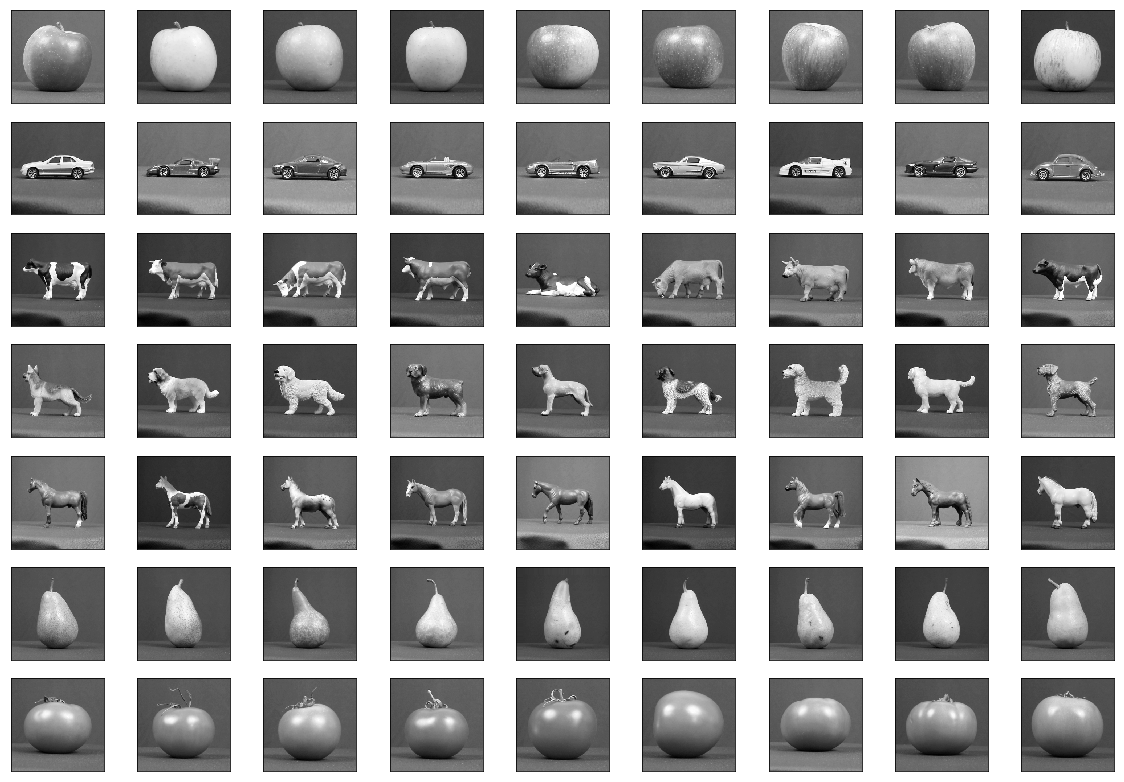

In [3]:
plt.figure(figsize=(20,14))
for i,im in enumerate(train_images):
    plt.subplot(7,9,i+1)
    plt.imshow(im, cmap='gray')
    plt.xticks([]), plt.yticks([])
plt.show()

## Feature Extraction

Use SIFT to extract keypoints and their 128-D descriptors, for each of the training images. 

Display the images with the extracted keypoints.


SIFT in OpenCV: 

- http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_sift_intro/py_sift_intro.html


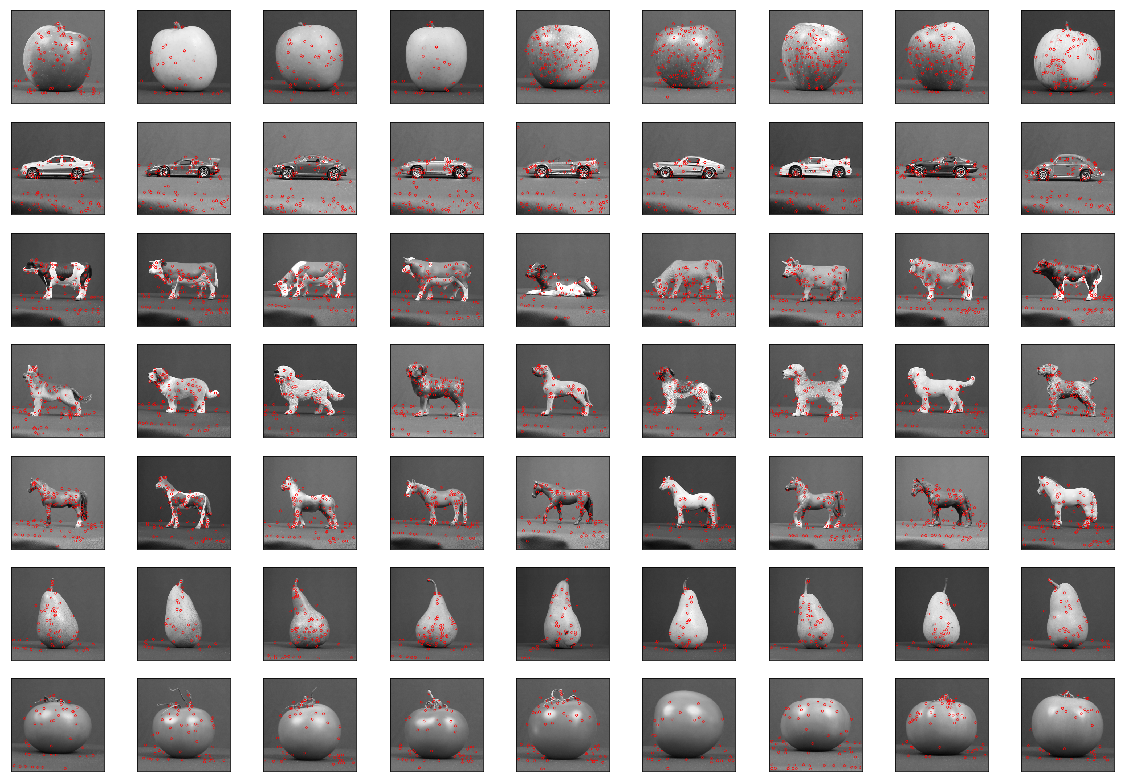

In [4]:
sift = cv2.xfeatures2d.SIFT_create(sigma=3, edgeThreshold=10.01, contrastThreshold=0.009)
# you might need to play with the SIFT parameters a little..
train_sifts_desc = []
train_desc_lbls = []
plt.figure(figsize=(20,14))
for i,im in enumerate(train_images):
    kp, des = sift.detectAndCompute(im,None)
    lbl = int(train_labels[i])
    for r in des:
        train_desc_lbls.append(lbl)
        train_sifts_desc.append(r)
    plt.subplot(7,9,i+1)
    plt.imshow(cv2.drawKeypoints(im,kp,None,color=(255,0,0)),'gray')
    #plt.scatter(kp[0:,], y, s=area, c=colors, alpha=0.5)
    plt.xticks([]), plt.yticks([])
plt.show()
#print(train_sifts)
# your code here..

## Vector Quantization

Concatenate all the descriptors together into a single big $N\times 128$ matrix ($N=?$)

Perform V.Q using k-means to cluster the feature-space into $K=25$ clusters.


K-means in OpenCV:
- http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_ml/py_kmeans/py_kmeans_opencv/py_kmeans_opencv.html



In [5]:
des_matrix = np.array(train_sifts_desc)
train_desc_lbls = np.array(train_desc_lbls)
# Define criteria = ( type, max_iter = 10 , epsilon = 1.0 )
criteria = (cv2.TERM_CRITERIA_EPS, 30,1)
ret,VQlabel,VQ=cv2.kmeans(des_matrix,25,None,criteria,50,cv2.KMEANS_RANDOM_CENTERS)
print('shape for label vector: ',VQlabel.shape)
print('shape for descriptors matrix: ',VQ.shape)
#print(ret,label,center)



shape for label vector:  (5703, 1)
shape for descriptors matrix:  (25, 128)


## Categories Representations

Use the result of the VQ to build a representation for each of the 7 image categories.

A representation is a histogram of all features (in all images of a given category) over the $K$ clusters.

Normalize each histogram, by the number of all features used to built it.

Organize the results in a $7\times K$ matrix. Display each one of the 7 histograms.

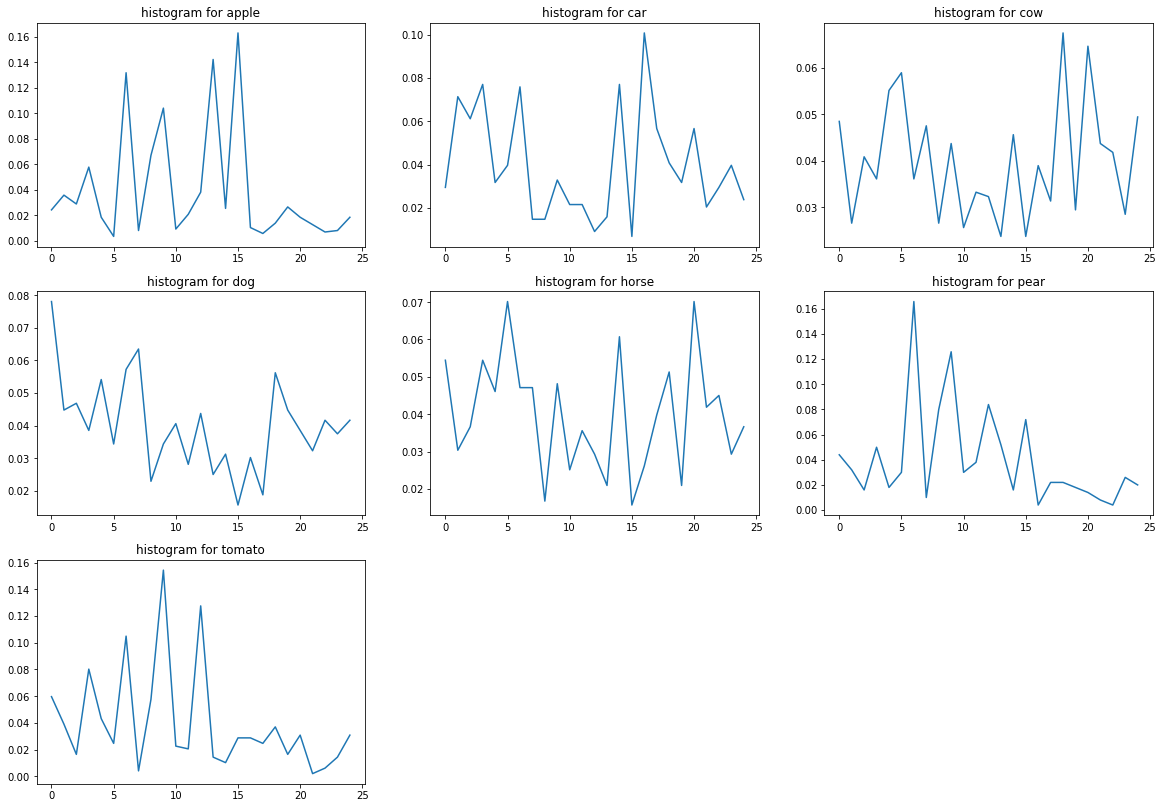

matrix shape:  (7, 25)


In [6]:
# your code here..
result = []
plt.figure(figsize=(20,14))
for i in range(7):
    msk = train_desc_lbls == i  
    vqLbls = VQlabel[msk].flatten()  
    hist = np.array(np.histogram(vqLbls, bins=25)[0])
    nphist = (hist / hist.sum())
    result.append(nphist)
    plt.subplot(3,3,i+1)
    plt.title('histogram for {}'.format(inv_dict[i]))
    plt.plot(nphist)  # arguments are passed to np.histogram
plt.show()
result = np.array(result)
result32 = result.astype('float32')
print('matrix shape: ',result.shape)


## Testing images

Load one of the testing images.

1. Extract SIFT keypoints and descriptors for the test image.
2. Use k-NN (with k=1) to assign each descriptor into one of the K clusters
3. Build a representation of the test-image, as a (normalized) histogram of its features over the $K$ clusters.
4. Display the image representation 
5. Find the nearest representation to the image from the set of 7 category representations, and print the matching category.

Repeat for all testing images.


Note: in step 5, you can  either do it yourself (like in Ex.5 Q.3), or use OpenCV's k-NN (with k=1):
- http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_ml/py_knn/py_knn_understanding/py_knn_understanding.html



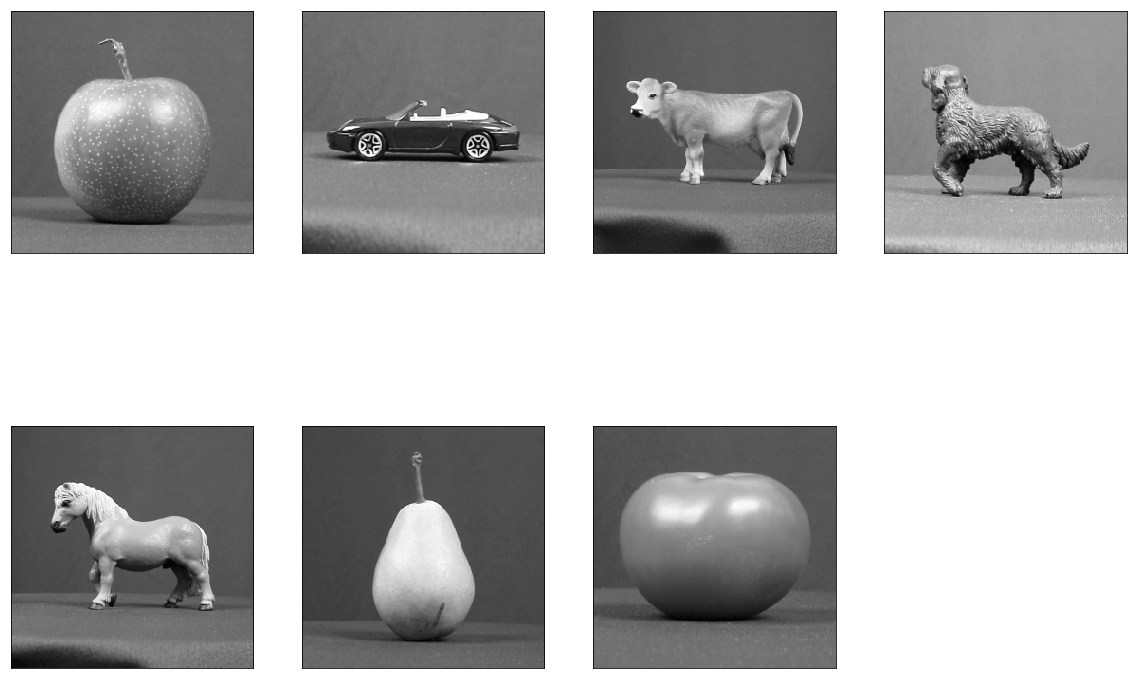

In [7]:
# your code here..
fnames=glob('test\*.png')

test_images = []
lenImgs = len(fnames)
test_labels = np.zeros(lenImgs)
plt.figure(figsize=(20,14))
for i,f in enumerate(fnames):
    plt.subplot(2,4,i+1)
    name,ext = f.split('.')
    name = re.sub(r'[\d_-]', '', name)
    name = name.split('\\')[-1]
    lbl = dict[name]
    test_labels[i] = lbl
    im = cv2.imread(f,0)
    plt.imshow(im, cmap='gray')
    plt.xticks([]), plt.yticks([])
    test_images.append(im)
plt.show()    

Success Rate is 100.0%


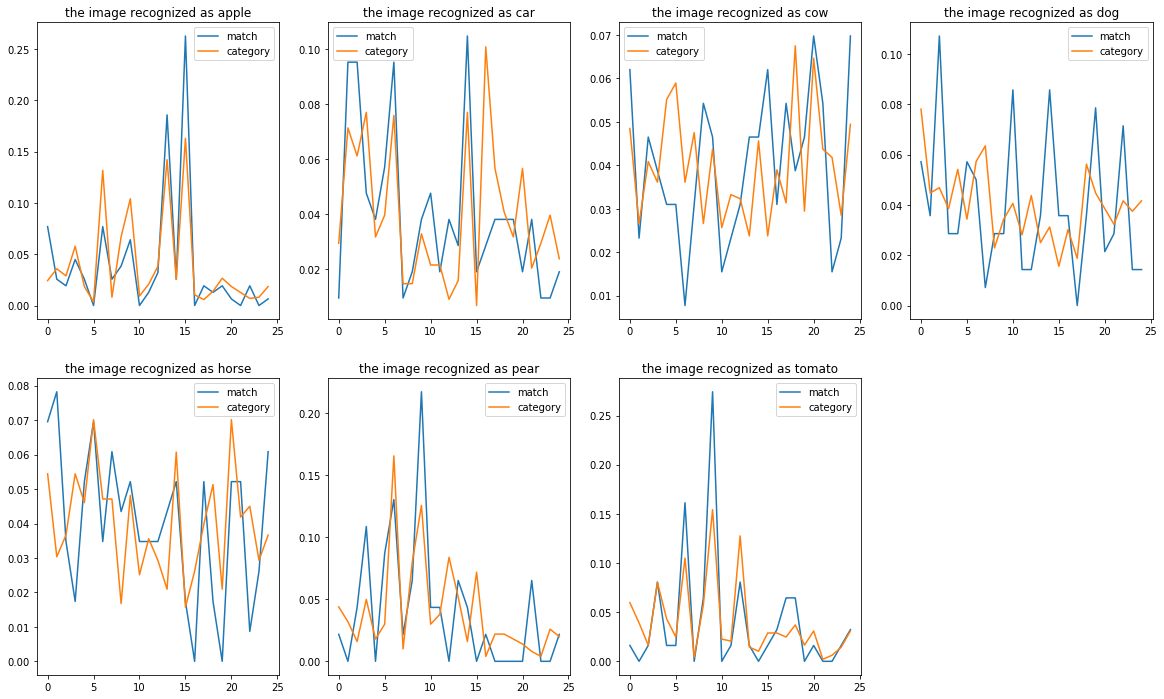

In [8]:
knn = cv2.ml.KNearest_create()
knn.train(VQ,cv2.ml.ROW_SAMPLE,np.arange(25))
knn_hist = cv2.ml.KNearest_create()
knn_hist.train(result32,cv2.ml.ROW_SAMPLE,np.arange(7))
matchCount = 0
plt.figure(figsize=(20,12))
for i,im in enumerate(test_images):
    kp_test, des_test = sift.detectAndCompute(im,None)
    ret, res,neighbours,dist = knn.findNearest(des_test,1)
    histRes = np.array(np.histogram(res.flatten(), bins=25)[0])
    histRes = histRes / histRes.sum()
    plt.subplot(2,4,i+1)
    plt.plot(histRes,label ='match')
    histRes = histRes.reshape(1,25).astype('float32')
    ret, matchRes,neighbours,dist = knn_hist.findNearest(histRes,1)
    match = int(matchRes.flatten())
    if(match == test_labels[i]):
        matchCount = matchCount + 1
    #print(neighbours,matchRes,inv_dict[match])
    plt.title('the image recognized as {}'.format(inv_dict[match]))
    plt.plot(result[match],label='category')
    plt.legend()
print("Success Rate is {}%".format( (matchCount/lenImgs)*100 ))
plt.show()


#ret, results,neighbours,dist = knn.find_nearest(desc, 1)


## Good Luck!